In [12]:
!pip install mlflow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
import mlflow

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt  # Import matplotlib

In [2]:
# 1. Embed ข้อความด้วย WangchanBERTa
def get_wangchanberta_embeddings(texts, model_name='airesearch/wangchanberta-base-att-spm-uncased', max_length=128):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length)
    with torch.no_grad():
        model_output = model(**encoded_inputs)
    embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings.numpy()

In [3]:
# 2. เตรียมข้อมูลสำหรับ Deep Learning
class SentimentDataset(Dataset):
    def __init__(self, embeddings, scores):
        self.embeddings = embeddings
        self.scores = scores

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        score = torch.tensor(self.scores[idx], dtype=torch.float32) # Ensure score is a tensor
        return embedding, score

In [4]:
# 3. สร้างโมเดล Deep Learning (RNN)
def create_model(input_size, hidden_size, num_layers, dropout_rate=0.5):
    class RNNWithDropout(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
            super(RNNWithDropout, self).__init__()
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
            self.dropout = nn.Dropout(dropout_rate)
            self.linear = nn.Linear(hidden_size, 3)

        def forward(self, x):
            output, hidden = self.rnn(x)
            output = self.dropout(output)
            output = output[:, -1, :] if output.ndim > 2 else output
            batch_size = output.shape[0]
            output = output.contiguous().view(batch_size, -1)
            output = self.linear(output)
            return output # Remove hidden from return

    model = RNNWithDropout(input_size, hidden_size, num_layers, dropout_rate)
    return model

In [5]:
# 4. Normalize Scores ด้วย StandardScaler
def normalize_scores(scores):
    scaler = StandardScaler()
    return scaler.fit_transform(scores), scaler

In [6]:
# 5. ประเมินโมเดล
def evaluate_model(model, test_loader, criterion, scaler):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for embeddings, scores in test_loader:
            output = model(embeddings) # Remove _ from unpacking
            loss = criterion(output, scores)
            total_loss += loss.item()
            predictions.extend(output.cpu().numpy())
            actuals.extend(scores.cpu().numpy())
    avg_loss = total_loss / len(test_loader)
    predictions = scaler.inverse_transform(np.array(predictions))
    actuals = scaler.inverse_transform(np.array(actuals))
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    return mse, mae, r2, avg_loss

In [7]:
# 6. สร้างและ Train โมเดลต่าง ๆ
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10, eval_interval=1):
    model.train()
    epoch_losses = []
    eval_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for embeddings, scores in train_loader:
            optimizer.zero_grad()
            output, _ = model(embeddings)
            loss = criterion(output, scores)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_epoch_loss:.4f}")

        if (epoch + 1) % eval_interval == 0:
            model.eval()
            eval_loss = 0
            with torch.no_grad():
                for eval_embeddings, eval_scores in test_loader:
                    eval_output, _ = model(eval_embeddings)
                    eval_loss_batch = criterion(eval_output, eval_scores)
                    eval_loss += eval_loss_batch.item()
            avg_eval_loss = eval_loss / len(test_loader)
            eval_losses.append(avg_eval_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Eval Loss: {avg_eval_loss:.4f}")
            model.train()
    return epoch_losses, eval_losses

In [24]:
class SentimentDataset(Dataset):
    def __init__(self, embeddings, scores):
        self.embeddings = embeddings
        self.scores = scores

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        score = torch.tensor(self.scores[idx], dtype=torch.float32)
        return embedding, score

def train_and_evaluate(df, epochs=100, batch_size=32, hidden_size=256, num_layers=4, eval_interval=5,
                       learning_rates=[0.00045, 0.000475, 0.0005, 0.000525, 0.00055],
                       dropout_rates=[0.275, 0.3, 0.325, 0.35],
                       weight_decays=[4.5e-06, 5e-06], patience=10):

    embeddings = get_wangchanberta_embeddings(df["complain_detail"].tolist())
    scores = df[["positive", "neutral", "negative"]].values
    normalized_scores, scaler = normalize_scores(scores)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, normalized_scores, test_size=0.3, random_state=42)
    train_dataset = SentimentDataset(X_train, y_train)
    test_dataset = SentimentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    input_size = embeddings.shape[1]

    best_eval_loss = float("inf")
    best_model = None
    best_params = {}

    for learning_rate in learning_rates:
        for dropout_rate in dropout_rates:
            for weight_decay in weight_decays:
                print(f"\nTraining with lr={learning_rate}, dr={dropout_rate}, wd={weight_decay}")
                model = create_model(input_size, hidden_size, num_layers, dropout_rate)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=False)

                epoch_losses, eval_losses = [], []
                no_improve_epochs = 0

                for epoch in range(epochs):
                    epoch_loss = train_model_epoch(model, train_loader, criterion, optimizer)
                    epoch_losses.append(epoch_loss)

                    if (epoch + 1) % eval_interval == 0:
                        eval_loss = evaluate_model_loss(model, test_loader, criterion)
                        eval_losses.append(eval_loss)
                        scheduler.step(eval_loss)
                        print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}, Eval Loss: {eval_loss:.4f}")

                        if eval_loss < best_eval_loss:
                            best_eval_loss = eval_loss
                            best_model = model.state_dict()
                            best_params = {"learning_rate": learning_rate, "dropout_rate": dropout_rate, "weight_decay": weight_decay}
                            no_improve_epochs = 0
                        else:
                            no_improve_epochs += 1
                            if no_improve_epochs >= patience:
                                print(f"Early stopping after {patience} epochs without improvement.")
                                break

                if best_model is not None:
                    model.load_state_dict(best_model)
                    mse, mae, r2, _ = evaluate_model(model, test_loader, criterion, scaler)
                    print(f"lr: {learning_rate:.6f}, dr: {dropout_rate:.3f}, wd: {weight_decay:.6e}, MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

                    plt.plot(epoch_losses, label="Train Loss")
                    eval_epochs = range(eval_interval, len(epoch_losses) + 1, eval_interval)
                    plt.plot(eval_epochs, eval_losses, label="Eval Loss")
                    plt.title(f"Training Loss (lr={learning_rate:.6f}, dr={dropout_rate:.3f}, wd={weight_decay:.6e})")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()
                    plt.show()

    # Print Best Results
    print("\nBest Model Results:")
    print(f"Best lr: {best_params['learning_rate']:.6f}, Best dr: {best_params['dropout_rate']:.3f}, Best wd: {best_params['weight_decay']:.6e}")
    if best_model is not None:
        model.load_state_dict(best_model)
        mse, mae, r2, _ = evaluate_model(model, test_loader, criterion, scaler)
        print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
        return mse, mae, r2, model, scaler, best_params
    else:
        print("No model was trained successfully.")
        return None, None, None, None, None, None

def train_model_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        # print(f"inputs shape: {inputs.size()}")
        # print(f"model(inputs) shape: {model(inputs).size()}")
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(f"outputs shape : {outputs.size()}")
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model_loss(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            # print(f"inputs shape: {inputs.size()}")
            # print(f"model(inputs) shape: {model(inputs).size()}")
            outputs = model(inputs)
            # print(f"outputs shape : {outputs.size()}")
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [9]:
# def train_and_evaluate(df, epochs=20, batch_size=32, hidden_size=256, num_layers=3, eval_interval=5,
#                        learning_rates=[0.0001, 0.00025, 0.0005], dropout_rates=[0.3, 0.4, 0.5],
#                        weight_decays=[4.5e-06, 5e-06]):
#     embeddings = get_wangchanberta_embeddings(df["complain_detail"].tolist())
#     scores = df[["positive", "neutral", "negative"]].values
#     normalized_scores, scaler = normalize_scores(scores)
#     X_train, X_test, y_train, y_test = train_test_split(embeddings, normalized_scores, test_size=0.3, random_state=42)
#     train_dataset = SentimentDataset(X_train, y_train)
#     test_dataset = SentimentDataset(X_test, y_test)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size)
#     input_size = embeddings.shape[1]

#     best_eval_loss = float("inf")
#     best_model = None
#     best_params = {}

#     for learning_rate in learning_rates:
#         for dropout_rate in dropout_rates:
#             for weight_decay in weight_decays:
#                 print(f"\nTraining with lr={learning_rate}, dr={dropout_rate}, wd={weight_decay}")
#                 model = create_model(input_size, hidden_size, num_layers, dropout_rate)
#                 criterion = nn.MSELoss()
#                 optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#                 epoch_losses, eval_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs, eval_interval)
#                 mse, mae, r2, _ = evaluate_model(model, test_loader, criterion, scaler)
#                 print(f"lr: {learning_rate:.6f}, dr: {dropout_rate:.3f}, wd: {weight_decay:.6e}, MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
#                 avg_final_eval_loss = eval_losses[-1] if eval_losses else float("inf")
#                 if avg_final_eval_loss < best_eval_loss:
#                     best_eval_loss = avg_final_eval_loss
#                     best_model = model
#                     best_params = {"learning_rate": learning_rate, "dropout_rate": dropout_rate, "weight_decay": weight_decay}
#                 plt.plot(epoch_losses, label="Train Loss")
#                 eval_epochs = range(eval_interval, epochs + 1, eval_interval)
#                 plt.plot(eval_epochs, eval_losses, label="Eval Loss")
#                 plt.title(f"Training Loss (lr={learning_rate:.6f}, dr={dropout_rate:.3f}, wd={weight_decay:.6e})")
#                 plt.xlabel("Epoch")
#                 plt.ylabel("Loss")
#                 plt.legend()
#                 plt.show()

#     # Print Best Results
#     print("\nBest Model Results:")
#     print(f"Best lr: {best_params['learning_rate']:.6f}, Best dr: {best_params['dropout_rate']:.3f}, Best wd: {best_params['weight_decay']:.6e}")
#     mse, mae, r2, _ = evaluate_model(best_model, test_loader, criterion, scaler)
#     print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

#     return mse, mae, r2, best_model, scaler, best_params

In [10]:
df = pd.read_excel("combined_data.xlsx")
df

,Unnamed: 0,complain_detail,positive,neutral,negative
0,0,การปรับแรงดันจุดซื้อขาย ระหว่าง PEA – EGAT ให้...,0.000000,0.400000,0.600000
1,1,ปัญหาแรงดันจุดซื้อขายระหว่าง PEA – EGAT มีค่าค...,0.000000,0.100000,0.900000
2,2,ปัญหาการตกหล่นของเอกสารขอดับไฟระหว่าง PEA – EGAT,0.000000,0.100000,0.900000
3,3,ขอให้ กฟผ.พิจารณาเพิ่มขนาดหม้อแปลง KT2A ทีส่ฟ....,0.000000,0.400000,0.600000
4,4,"On site spare parts checking, Present WI how t...",0.000000,1.000000,0.000000
...,...,...,...,...,...
1600,530,การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...,0.313192,0.133374,0.553434
1601,531,การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...,0.000000,0.332710,0.667290
1602,532,อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...,0.000000,0.601365,0.398635
1603,533,อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...,0.000000,0.265460,0.734540


embeddings type: <class 'numpy.ndarray'>
normalized_scores type: <class 'numpy.ndarray'>

Training with lr=0.00075, dr=0.2, wd=4.5e-06


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5, Train Loss: 0.4348, Eval Loss: 0.4185
Epoch 10, Train Loss: 0.2434, Eval Loss: 0.2996
Epoch 15, Train Loss: 0.1560, Eval Loss: 0.2568
Epoch 20, Train Loss: 0.0962, Eval Loss: 0.2045
Epoch 25, Train Loss: 0.0889, Eval Loss: 0.1987
Epoch 30, Train Loss: 0.0501, Eval Loss: 0.1716
Epoch 35, Train Loss: 0.0818, Eval Loss: 0.1421
Epoch 40, Train Loss: 0.0380, Eval Loss: 0.1056
Epoch 45, Train Loss: 0.0398, Eval Loss: 0.1372
Epoch 50, Train Loss: 0.0227, Eval Loss: 0.0923
Epoch 55, Train Loss: 0.0159, Eval Loss: 0.1008
Epoch 60, Train Loss: 0.0139, Eval Loss: 0.0772
Epoch 65, Train Loss: 0.0122, Eval Loss: 0.0782
Epoch 70, Train Loss: 0.0113, Eval Loss: 0.0769
lr: 0.000750, dr: 0.200, wd: 4.500000e-06, MSE: 0.0067, MAE: 0.0373, R2: 0.9190


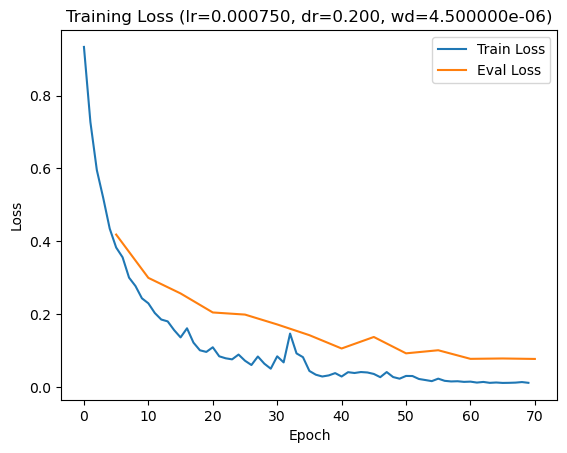


Best Model Results:
Best lr: 0.000750, Best dr: 0.200, Best wd: 4.500000e-06
MSE: 0.0067, MAE: 0.0373, R2: 0.9190
🏃 View run RNN_Attempt_4 at: http://127.0.0.1:5000/#/experiments/282275017264249914/runs/22f0fc9f34d341a08ee638e6974ee23b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/282275017264249914

Training with lr=0.000755, dr=0.2, wd=4.5e-06


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5, Train Loss: 0.4350, Eval Loss: 0.4654
Epoch 10, Train Loss: 0.2023, Eval Loss: 0.3380
Epoch 15, Train Loss: 0.1493, Eval Loss: 0.2084
Epoch 20, Train Loss: 0.1987, Eval Loss: 0.2055
Epoch 25, Train Loss: 0.0789, Eval Loss: 0.1878
Epoch 30, Train Loss: 0.0638, Eval Loss: 0.1270
Epoch 35, Train Loss: 0.0384, Eval Loss: 0.1029
Epoch 40, Train Loss: 0.0337, Eval Loss: 0.1488
Epoch 45, Train Loss: 0.0225, Eval Loss: 0.1077
Epoch 50, Train Loss: 0.0179, Eval Loss: 0.0840
Epoch 55, Train Loss: 0.0291, Eval Loss: 0.0865
Epoch 60, Train Loss: 0.0221, Eval Loss: 0.0776
Epoch 65, Train Loss: 0.0151, Eval Loss: 0.0913
Epoch 70, Train Loss: 0.0158, Eval Loss: 0.0758
lr: 0.000755, dr: 0.200, wd: 4.500000e-06, MSE: 0.0067, MAE: 0.0367, R2: 0.9195


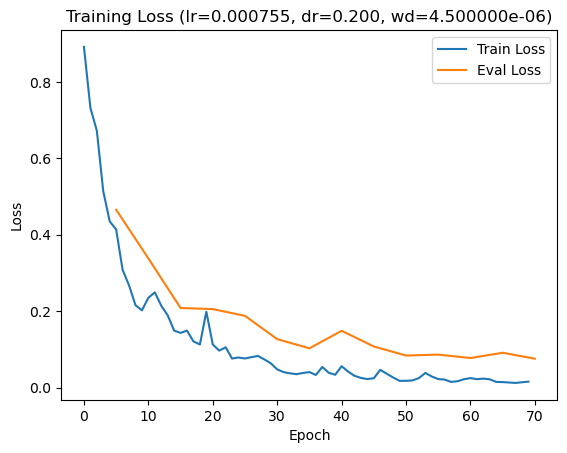


Best Model Results:
Best lr: 0.000755, Best dr: 0.200, Best wd: 4.500000e-06
MSE: 0.0067, MAE: 0.0367, R2: 0.9195
🏃 View run RNN_Attempt_5 at: http://127.0.0.1:5000/#/experiments/282275017264249914/runs/996ad6a460144bcea8ef94d0db2781d4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/282275017264249914

Training with lr=0.0008, dr=0.2, wd=4.5e-06


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5, Train Loss: 0.4172, Eval Loss: 0.4099
Epoch 10, Train Loss: 0.2139, Eval Loss: 0.3592
Epoch 15, Train Loss: 0.1365, Eval Loss: 0.2141
Epoch 20, Train Loss: 0.0901, Eval Loss: 0.2047
Epoch 25, Train Loss: 0.0904, Eval Loss: 0.1507
Epoch 30, Train Loss: 0.0534, Eval Loss: 0.1674
Epoch 35, Train Loss: 0.0554, Eval Loss: 0.1366
Epoch 40, Train Loss: 0.0375, Eval Loss: 0.1439
Epoch 45, Train Loss: 0.0294, Eval Loss: 0.0945
Epoch 50, Train Loss: 0.0215, Eval Loss: 0.0903
Epoch 55, Train Loss: 0.0245, Eval Loss: 0.1159
Epoch 60, Train Loss: 0.0245, Eval Loss: 0.0804
Epoch 65, Train Loss: 0.0199, Eval Loss: 0.0831
Epoch 70, Train Loss: 0.0153, Eval Loss: 0.0760
lr: 0.000800, dr: 0.200, wd: 4.500000e-06, MSE: 0.0067, MAE: 0.0379, R2: 0.9196


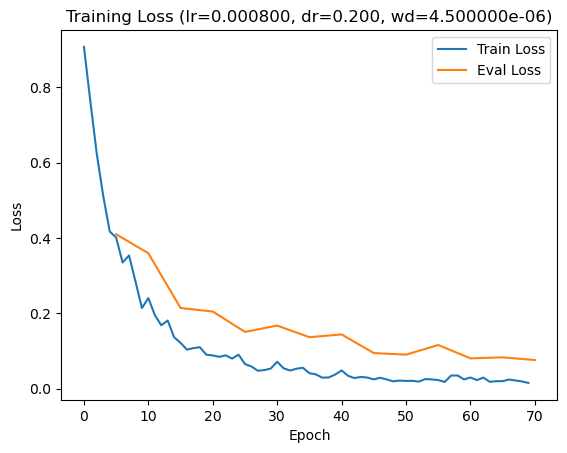


Best Model Results:
Best lr: 0.000800, Best dr: 0.200, Best wd: 4.500000e-06
MSE: 0.0067, MAE: 0.0379, R2: 0.9196
🏃 View run RNN_Attempt_6 at: http://127.0.0.1:5000/#/experiments/282275017264249914/runs/0e33db55f0be4a23b1e976e77268eac0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/282275017264249914
RNN: MSE=0.006695783231407404, MAE=0.037887051701545715, R-squared=0.9195656776428223


In [26]:
embeddings = get_wangchanberta_embeddings(df["complain_detail"].tolist())
scores = df[["positive", "neutral", "negative"]].values
normalized_scores, scaler = normalize_scores(scores)

print(f"embeddings type: {type(embeddings)}")
print(f"normalized_scores type: {type(normalized_scores)}")


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("sentiment_model_rnn")

learning_rates_choice = [0.00075 , 0.000755 , 0.00080]
                      
for i , lr in enumerate(learning_rates_choice, start=4):
    with mlflow.start_run(run_name=f"RNN_Attempt_{i}"):
        mse_rnn, mae_rnn, r2_rnn, model_rnn, scaler_rnn, best_params_rnn = train_and_evaluate(
            df.copy(),
            epochs=70,  # You can adjust this
            hidden_size=256,
            num_layers=4,
            learning_rates=[lr],
            dropout_rates=[0.2],
            weight_decays=[4.5e-06]
        )

         # Log metric ลง MLflow
        mlflow.log_metric("MSE", mse_rnn)
        mlflow.log_metric("MAE", mae_rnn)
        mlflow.log_metric("R-squared", r2_rnn)
        
        params_to_log = {
            "epochs": 70,
            "hidden_size": 256,
            "num_layers": 4,
        }
            
        # Log parameters 
        mlflow.log_params(params_to_log)

print(f"RNN: MSE={mse_rnn}, MAE={mae_rnn}, R-squared={r2_rnn}")

In [ ]:
# 7. ฟังก์ชันสำหรับทำนาย Sentiment Score จากข้อความ
def predict_sentiment(text, model, scaler, model_type='RNN'):
    embedding = get_wangchanberta_embeddings([text])  # Assuming this returns a NumPy array

    # Ensure embedding is a NumPy array
    if not isinstance(embedding, np.ndarray):
        raise TypeError("Embedding must be a NumPy array")

    embedding_tensor = torch.tensor(embedding, dtype=torch.float)

    with torch.no_grad():
        # Corrected line: Call the model directly
        output = model(embedding_tensor) # เปลี่ยนตรงนี้

        # Assuming your model outputs a single value or a 1D tensor
        # You might need to adjust this depending on your model's output shape
        score = scaler.inverse_transform(output.numpy())

    return score

In [ ]:
# Example prediction
text_to_predict = "สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK2-7082 เมื่อวันที่ 24 ก.พ. 2557 เวลา 13.03 น. วงจร PK2-7082 มีการทำงาน Trip Lock out ทำเกิดกระแสไฟฟ้าขัดข้องในพื้นที่เมืองภูเก็ตบางส่วน,หาดกะตะ และหาดกะรน โหลดหาย 49.8 MW ศูนย์ควบคุมการจ่ายไฟ จ.ภูเก็ต ขอทราบรายละเอียดการทำงานของอุปกรณ์ป้องกันดังกล่าว เพื่อทำการตรวจสอบหาสาเหตุและวางแนวทางการแก้ไขต่อไป"
predicted_scores = predict_sentiment(text_to_predict, model_rnn, scaler_rnn, model_type='RNN') # Use the best model
predicted_scores

In [ ]:
complaints = [
    "ต้องการให้มีการตรวจสอบคุณภาพของอุปกรณ์ที่ติดตั้งให้ถี่ถ้วนกว่านี้ เนื่องจากพบปัญหาอุปกรณ์ชำรุดหลังจากติดตั้งได้ไม่นาน",
    "อยากให้ปรับปรุงระบบแจ้งเตือนเมื่อเกิดเหตุขัดข้องให้รวดเร็วและแม่นยำกว่านี้ เพื่อที่จะได้เตรียมตัวรับมือได้ทัน",
    "ขอให้ทาง กฟผ. ช่วยเร่งแก้ไขปัญหาไฟตก ไฟดับ ที่เกิดขึ้นบ่อยครั้งในพื้นที่นี้ด้วยครับ สร้างความเดือดร้อนในการใช้ชีวิตประจำวันมาก",
    "อยากให้มีช่องทางในการติดต่อกับเจ้าหน้าที่ที่หลากหลายกว่านี้ เช่น มี Chat Bot หรือ Line Official Account เพื่อความสะดวกในการสอบถามข้อมูล",
    "ขอให้มีการอบรมให้ความรู้เกี่ยวกับการใช้ไฟฟ้าอย่างปลอดภัยแก่ประชาชนทั่วไป เพื่อลดอุบัติเหตุที่อาจเกิดขึ้น",
    "อยากให้มีการประชาสัมพันธ์ข้อมูลข่าวสารเกี่ยวกับการดำเนินงานของ กฟผ. ให้ประชาชนได้รับทราบอย่างต่อเนื่องและทั่วถึง",
    "ขอให้มีการปรับปรุงภูมิทัศน์บริเวณสถานีไฟฟ้าให้มีความสวยงามและเป็นระเบียบเรียบร้อย เพื่อสร้างภาพลักษณ์ที่ดี",
    "อยากให้มีการส่งเสริมการใช้พลังงานสะอาดและพลังงานทดแทนให้มากขึ้น เพื่อลดผลกระทบต่อสิ่งแวดล้อม",
    "ขอให้มีการตรวจสอบและบำรุงรักษาสายส่งและอุปกรณ์ไฟฟ้าอย่างสม่ำเสมอ เพื่อป้องกันปัญหาไฟดับที่อาจเกิดขึ้น",
    "อยากให้มีการรับฟังความคิดเห็นของประชาชนอย่างสม่ำเสมอ เพื่อนำมาปรับปรุงการดำเนินงานให้ดียิ่งขึ้น",
    "ขอให้มีการพัฒนาระบบการชำระค่าไฟฟ้าให้มีความสะดวกและหลากหลายช่องทางมากขึ้น",
    "อยากให้มีการให้ความช่วยเหลือประชาชนที่ได้รับผลกระทบจากเหตุภัยพิบัติทางธรรมชาติอย่างทันท่วงที",
    "ขอให้มีการส่งเสริมการประหยัดพลังงานในภาคครัวเรือนและภาคอุตสาหกรรม",
    "อยากให้มีการควบคุมราคาค่าไฟฟ้าให้มีความเหมาะสมและเป็นธรรมกับผู้บริโภค",
    "ขอให้มีการปรับปรุงการให้บริการลูกค้าให้มีความรวดเร็วและมีประสิทธิภาพมากยิ่งขึ้น",
    "อยากให้มีการสร้างความเข้าใจและความสัมพันธ์ที่ดีกับชุมชนโดยรอบสถานีไฟฟ้า",
    "ขอให้มีการสนับสนุนการวิจัยและพัฒนาเทคโนโลยีด้านพลังงานไฟฟ้าอย่างต่อเนื่อง",
    "อยากให้มีการเปิดเผยข้อมูลการดำเนินงานของ กฟผ. ให้ประชาชนสามารถเข้าถึงและตรวจสอบได้",
    "ขอให้มีการส่งเสริมความโปร่งใสในการดำเนินงานของ กฟผ.",
    "อยากให้มีการพัฒนาบุคลากรของ กฟผ. ให้มีความรู้ความสามารถและมีคุณธรรมจริยธรรม"
]
complaints2 = [
    "ขอให้มีการปรับปรุงระบบการจ่ายไฟฟ้าให้มีความเสถียรมากขึ้น เนื่องจากพบปัญหาไฟตกบ่อยในช่วงฤดูฝน",
    "อยากให้มีการเพิ่มช่องทางการแจ้งเหตุไฟฟ้าขัดข้องให้หลากหลายมากขึ้น เช่น ผ่านแอปพลิเคชันบนมือถือ",
    "ขอให้มีการปรับปรุงการให้บริการข้อมูลข่าวสารผ่านทางเว็บไซต์ให้มีความทันสมัยและใช้งานง่ายมากขึ้น",
    "อยากให้มีการส่งเสริมการมีส่วนร่วมของประชาชนในการตรวจสอบการดำเนินงานของ กฟผ.",
    "ขอให้มีการปรับปรุงระบบการจัดการเรื่องร้องเรียนให้มีความรวดเร็วและมีประสิทธิภาพมากขึ้น",
    "อยากให้มีการส่งเสริมการใช้เทคโนโลยีใหม่ๆ ในการผลิตและส่งจ่ายไฟฟ้า",
    "ขอให้มีการปรับปรุงการสื่อสารกับประชาชนให้มีความชัดเจนและเข้าใจง่ายมากขึ้น",
    "อยากให้มีการส่งเสริมการพัฒนาบุคลากรให้มีความเชี่ยวชาญในด้านต่างๆ ที่เกี่ยวข้องกับการไฟฟ้า",
    "ขอให้มีการปรับปรุงการทำงานให้มีความปลอดภัยมากขึ้น เพื่อลดอุบัติเหตุที่อาจเกิดขึ้น",
    "อยากให้มีการส่งเสริมการอนุรักษ์พลังงานในทุกภาคส่วน",
    "ขอให้มีการปรับปรุงการให้บริการลูกค้าให้มีความเป็นมืออาชีพมากขึ้น",
    "อยากให้มีการส่งเสริมการท่องเที่ยวเชิงอนุรักษ์ในพื้นที่ที่มีโรงไฟฟ้าตั้งอยู่",
    "ขอให้มีการปรับปรุงการบริหารจัดการให้มีประสิทธิภาพมากขึ้น",
    "อยากให้มีการส่งเสริมการลงทุนในโครงสร้างพื้นฐานด้านพลังงานไฟฟ้า",
    "ขอให้มีการปรับปรุงการดำเนินงานให้มีความรับผิดชอบต่อสังคมและสิ่งแวดล้อมมากขึ้น",
    "อยากให้มีการส่งเสริมการสร้างงานและสร้างรายได้ให้กับประชาชนในพื้นที่ที่มีโรงไฟฟ้าตั้งอยู่",
    "ขอให้มีการปรับปรุงการวางแผนการผลิตไฟฟ้าให้สอดคล้องกับความต้องการของประชาชน",
    "อยากให้มีการส่งเสริมการพัฒนาเทคโนโลยีพลังงานทดแทนให้มีประสิทธิภาพมากขึ้น",
    "ขอให้มีการปรับปรุงการกระจายไฟฟ้าให้ทั่วถึงและเป็นธรรม",
    "อยากให้มีการส่งเสริมการพัฒนาองค์กรให้มีความยั่งยืนในระยะยาว"
]

In [ ]:
# Predict sentiment for each complaint
def run(complaints):
    predicted_sentiments = []
    for complaint in complaints:
        scores = predict_sentiment(complaint, model_rnn, scaler_rnn, model_type='RNN')
        predicted_sentiments.append(scores)
    
    # Print the results
    for i, complaint in enumerate(complaints):
        print(f"Complaint: {complaint}")
        print(f"Predicted Scores: {predicted_sentiments[i]}")
        print("-" * 20)

In [ ]:
run(complaints)

In [ ]:
run(complaints2)

In [ ]:
all_reviews = [
  # รีวิว/ความคิดเห็นเกี่ยวกับธุรกิจการผลิตไฟฟ้า
    "โรงไฟฟ้าพลังงานหมุนเวียนของ กฟผ. ช่วยลดผลกระทบต่อสิ่งแวดล้อมได้ดีมากครับ ขอชื่นชม",
    "อยากให้เพิ่มจำนวนโรงไฟฟ้าพลังงานแสงอาทิตย์ให้มากขึ้น เพื่อตอบสนองความต้องการใช้พลังงานสะอาด",
    "โรงไฟฟ้าพลังความร้อนร่วม มีประสิทธิภาพในการผลิตไฟฟ้าสูงมาก แต่ก็อยากให้ควบคุมการปล่อยมลพิษให้เข้มงวดกว่านี้",
    "การรับซื้อไฟฟ้าจากผู้ผลิตเอกชนรายเล็ก ช่วยส่งเสริมผู้ประกอบการในท้องถิ่นได้ดีครับ",
    "การรับซื้อไฟฟ้าจากประเทศเพื่อนบ้าน ช่วยให้มีแหล่งพลังงานที่หลากหลายมากขึ้น",
    "ปัญหาไฟตกไฟดับยังคงเกิดขึ้นบ้างในบางพื้นที่ อยากให้ กฟผ. ปรับปรุงระบบส่งไฟฟ้าให้มีเสถียรภาพมากขึ้น",
    "อยากให้มีข้อมูลเกี่ยวกับแผนการก่อสร้างโรงไฟฟ้าแห่งใหม่ๆ ให้ประชาชนได้รับทราบมากขึ้น",
    "การมีโรงไฟฟ้าหลากหลายประเภท ช่วยให้มีแหล่งพลังงานสำรองที่มั่นคง",
    "อยากให้ กฟผ. ลงทุนในเทคโนโลยีการผลิตไฟฟ้าที่ทันสมัยมากขึ้น เพื่อลดต้นทุนและเพิ่มประสิทธิภาพ",
    "การบำรุงรักษาโรงไฟฟ้าเป็นสิ่งสำคัญ ควรมีแผนการตรวจสอบและบำรุงรักษาที่เข้มงวด",
    "โรงไฟฟ้าพลังน้ำ เป็นแหล่งพลังงานสะอาดที่สำคัญ อยากให้มีการบริหารจัดการน้ำให้มีประสิทธิภาพ",
    "การผลิตไฟฟ้าจากพลังงานลม เป็นทางเลือกที่ดีสำหรับอนาคต",
    "โรงไฟฟ้าดีเซล ควรใช้ในกรณีฉุกเฉินเท่านั้น เพื่อลดผลกระทบต่อสิ่งแวดล้อม",
    "อยากให้มีข้อมูลเกี่ยวกับการปล่อยมลพิษของโรงไฟฟ้าแต่ละแห่งให้ประชาชนเข้าถึงได้ง่าย",
    "การมีส่วนร่วมของชุมชนในการวางแผนและตัดสินใจเกี่ยวกับโรงไฟฟ้า เป็นสิ่งสำคัญ",
    "กฟผ. ควรให้ความสำคัญกับการลดผลกระทบต่อสิ่งแวดล้อมและชุมชน",
    "อยากให้มีการลงทุนในเทคโนโลยีการดักจับและกักเก็บคาร์บอนไดออกไซด์",
    "การมีแหล่งพลังงานที่หลากหลาย ช่วยลดความเสี่ยงจากการพึ่งพาแหล่งพลังงานใดแหล่งพลังงานหนึ่ง",
    "กฟผ. ควรเป็นผู้นำในการเปลี่ยนผ่านสู่พลังงานสะอาด",
    "อยากให้มีการส่งเสริมการใช้พลังงานแสงอาทิตย์บนหลังคาบ้านและอาคาร",
    "การตรวจสอบตัว VT CT ที่อยู่ในระบบ ว่าถึงช่วงกำหนดเปลี่ยนแล้วหรือไม่ หากถึงเวลาเปลี่ยนควรเปลี่ยน บางครั้งพบว่า VT ชำรุด ไม่สามารถออกหน่วยได้ใช้วิธีการเฉลี่ย",
    "อยากทราบข้อมูลเกี่ยวกับขั้นตอนการขออนุญาตติดตั้งโซลาร์ฟาร์มขนาดใหญ่",
    "มีปัญหาไฟตกบ่อยในช่วงฤดูฝน รบกวนตรวจสอบและแก้ไขด้วยครับ",
    "การยืนยันการซื้อขายไฟฟ้า ควรทำให้รวดเร็วขึ้น โดยเฉพาะในช่วงวันหยุด",
    "อยากทราบข้อมูลเกี่ยวกับแผนการพัฒนาโรงไฟฟ้าพลังงานนิวเคลียร์ของ กฟผ.",
    "การมีส่วนร่วมของชุมชนในการตัดสินใจเรื่องโรงไฟฟ้า ควรเปิดโอกาสให้มากขึ้น",
    "ร้องเรียนเรื่องเสียงดังจากโรงไฟฟ้าใกล้บ้าน รบกวนตรวจสอบด้วยครับ",
    "อยากให้มีการจัดกิจกรรมให้ความรู้เกี่ยวกับพลังงานสะอาดแก่ประชาชนมากขึ้น",
    "อยากทราบข้อมูลเกี่ยวกับโครงการสนับสนุนการติดตั้งโซลาร์รูฟท็อปสำหรับครัวเรือน",
    "ชื่นชมการทำงานของเจ้าหน้าที่ กฟผ. ที่แก้ไขปัญหาไฟดับได้อย่างรวดเร็ว",
    
    # รีวิว/ความคิดเห็นเกี่ยวกับธุรกิจการส่งไฟฟ้า
    "ระบบส่งไฟฟ้าของ กฟผ. ครอบคลุมทั่วประเทศ ทำให้มีไฟฟ้าใช้ได้อย่างทั่วถึง",
    "ปัญหาไฟตกไฟดับยังคงเกิดขึ้นบ้างในบางพื้นที่ อยากให้ปรับปรุงระบบส่งไฟฟ้าให้มีเสถียรภาพมากขึ้น",
    "อยากให้มีข้อมูลเกี่ยวกับการบำรุงรักษาระบบส่งไฟฟ้าให้ประชาชนได้รับทราบมากขึ้น",
    "การมีระบบส่งไฟฟ้าแรงดันสูง ช่วยให้ส่งไฟฟ้าได้ในปริมาณมากและระยะทางไกล",
    "อยากให้มีการลงทุนในเทคโนโลยี Smart Grid เพื่อเพิ่มประสิทธิภาพและความมั่นคงของระบบส่งไฟฟ้า",
    "การบำรุงรักษาสายส่งไฟฟ้าแรงสูง เป็นงานที่อันตรายและมีความเสี่ยงสูง ควรมีมาตรการความปลอดภัยที่เข้มงวด",
    "อยากให้มีการลดผลกระทบของสายส่งไฟฟ้าต่อสิ่งแวดล้อมและสุขภาพของประชาชน",
    "การมีส่วนร่วมของชุมชนในการวางแผนและตัดสินใจเกี่ยวกับระบบส่งไฟฟ้า เป็นสิ่งสำคัญ",
    "กฟผ. ควรให้ความสำคัญกับการลดการสูญเสียพลังงานในระบบส่งไฟฟ้า",
    "อยากให้มีการใช้สายส่งไฟฟ้าใต้ดินในพื้นที่ชุมชน เพื่อลดผลกระทบต่อทัศนียภาพ",
    "การมีระบบควบคุมและป้องกันที่ทันสมัย ช่วยลดความเสี่ยงจากไฟฟ้าดับ",
    "อยากให้มีการตรวจสอบและบำรุงรักษาสถานีไฟฟ้าแรงสูงอย่างสม่ำเสมอ",
    "การมีระบบสื่อสารและโทรคมนาคมที่ทันสมัย ช่วยให้ควบคุมและจัดการระบบส่งไฟฟ้าได้อย่างมีประสิทธิภาพ",
    "อยากให้มีการฝึกอบรมและพัฒนาบุคลากรให้มีความเชี่ยวชาญด้านระบบส่งไฟฟ้า",
    "การมีระบบสำรองฉุกเฉิน ช่วยให้มีไฟฟ้าใช้ได้อย่างต่อเนื่องในกรณีเกิดเหตุฉุกเฉิน",
    "กฟผ. ควรให้ความสำคัญกับการลดผลกระทบต่อสิ่งแวดล้อมและชุมชน",
    "อยากให้มีการลงทุนในเทคโนโลยีการป้องกันฟ้าผ่า เพื่อลดปัญหาไฟตกไฟดับ",
    "การมีแหล่งพลังงานสำรองที่มั่นคง ช่วยให้มีไฟฟ้าใช้ได้อย่างต่อเนื่องในกรณีเกิดเหตุฉุกเฉิน",
    "กฟผ. ควรเป็นผู้นำในการพัฒนาระบบส่งไฟฟ้าที่ทันสมัยและมีประสิทธิภาพ",
    "อยากให้มีการส่งเสริมการใช้เทคโนโลยี Smart Grid เพื่อเพิ่มประสิทธิภาพและความมั่นคงของระบบส่งไฟฟ้า",
    "ปัญหา Trip Reclose เนื่องจากฟ้าผ่าบ่อย ในปีที่ผ่านมา เหมือนจะมีปัญหา Trip Reclose เนื่องจากฟ้าผ่าบ่อยกว่าทุกปี ส่งผลให้เกิด Voltage Dip เป็นพื้นที่บริเวณกว้าง",
    "อยากทราบขั้นตอนการขอเชื่อมต่อระบบไฟฟ้าของโรงงานอุตสาหกรรมขนาดใหญ่",
    "สายส่งไฟฟ้าแรงสูงใกล้บ้านมีเสียงดัง รบกวนตรวจสอบและแก้ไขด้วยครับ",
    "อยากทราบข้อมูลเกี่ยวกับแผนการพัฒนาระบบสายส่งไฟฟ้าใต้ดินในพื้นที่กรุงเทพฯ",
    "การมีส่วนร่วมของชุมชนในการวางแผนระบบสายส่งไฟฟ้า ควรเปิดโอกาสให้มากขึ้น",
    "ร้องเรียนเรื่องสายส่งไฟฟ้าแรงสูงกีดขวางการก่อสร้างบ้าน รบกวนตรวจสอบด้วยครับ",
    "อยากให้มีการจัดกิจกรรมให้ความรู้เกี่ยวกับความปลอดภัยในการอยู่ใกล้สายส่งไฟฟ้าแรงสูง",
    "อยากทราบข้อมูลเกี่ยวกับโครงการปรับปรุงระบบส่งไฟฟ้าในพื้นที่ชนบท",
    "ชื่นชมการทำงานของเจ้าหน้าที่ กฟผ. ที่แก้ไขปัญหาไฟดับได้อย่างรวดเร็ว",
    "อยากให้ตรวจสอบเสาไฟฟ้าแรงสูงต้นที่อยู่หน้าบ้านของผมว่ามีรอยร้าวหรือไม่",

    # รีวิว/ความคิดเห็นเกี่ยวกับธุรกิจอื่นๆ (โรงไฟฟ้าและระบบส่ง)
    "งานวิศวกรรมและก่อสร้างโรงไฟฟ้าของ กฟผ. มีคุณภาพและได้มาตรฐาน",
    "อยากให้มีการเปิดเผยข้อมูลเกี่ยวกับงานวิศวกรรมและก่อสร้างโรงไฟฟ้าให้มากขึ้น",
    "งานเดินเครื่องและบำรุงรักษาโรงไฟฟ้าของ กฟผ. มีประสิทธิภาพและเชื่อถือได้",
    "อยากให้มีการฝึกอบรมและพัฒนาบุคลากรให้มีความเชี่ยวชาญด้านงานเดินเครื่องและบำรุงรักษาโรงไฟฟ้า",
    "งานบำรุงรักษาระบบส่งไฟฟ้าของ กฟผ. มีความสำคัญต่อความมั่นคงของระบบไฟฟ้า",
    "อยากให้มีการตรวจสอบและบำรุงรักษาสายส่งไฟฟ้าแรงสูงอย่างสม่ำเสมอ",
    "ธุรกิจโทรคมนาคมของ กฟผ. ช่วยให้มีการสื่อสารที่รวดเร็วและมีประสิทธิภาพ",
    "อยากให้มีการขยายโครงข่ายโทรคมนาคมให้ครอบคลุมพื้นที่มากขึ้น",
    "การให้บริการโครงข่ายโทรคมนาคมผ่านเส้นใยแก้วนำแสงของ กฟผ. มีความน่าสนใจ",
    "อยากให้มีการโปรโมทบริการโทรคมนาคมของ กฟผ. ให้มากขึ้น",
    "กฟผ. ควรให้ความสำคัญกับความปลอดภัยในการทำงานของบุคลากร",
    "อยากให้มีการลดผลกระทบต่อสิ่งแวดล้อมจากงานก่อสร้างและบำรุงรักษา",
    "การมีส่วนร่วมของชุมชนในการวางแผนและตัดสินใจเกี่ยวกับงานก่อสร้างและบำรุงรักษา เป็นสิ่งสำคัญ",
]

In [ ]:
run(all_reviews)